In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import logging
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [30]:
df = pd.read_csv('training_file_data/final_file.csv')
df.head()
df_1 =df.copy()

In [2]:
dataset = pd.read_csv("../cluster_data.csv")
dataset.head(5)

,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-7,Sensor-8,Sensor-9,Sensor-10,Sensor-11,...,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Output,Cluster
0,2946.600802,2411.853074,2195.860926,1468.848673,-0.011154,102.772606,-1.096698,1.511426,-0.004110,-0.010250,...,0.509105,1.552851,-1.916605,-0.779948,0.037742,0.009604,0.001591,83.311361,1.0,2
1,3029.025889,2577.516148,2114.787497,843.481073,0.143376,95.279031,0.181486,1.407653,0.001346,-0.003198,...,0.493732,0.269608,1.432439,1.809433,0.020363,0.011476,0.011434,128.057477,1.0,1
2,2801.115780,2414.153308,2169.254013,1955.286683,-0.141322,105.387662,-0.325164,1.521377,0.013903,0.001713,...,0.502691,-2.321414,1.013503,0.024148,0.043088,0.024518,0.004945,2.079972,1.0,2
3,3074.476235,2505.247970,2256.611428,829.207099,0.531459,94.170368,-1.366607,1.427549,-0.013147,-0.001454,...,0.499002,-0.687576,-0.928198,0.933000,0.014775,0.008555,0.008123,-11.776452,1.0,0
4,3112.871126,2513.782809,2157.899906,263.734359,1.556179,81.186066,0.399515,1.461490,-0.014813,-0.001170,...,0.499044,0.572797,-0.849394,-1.262972,0.016782,0.027451,0.006300,90.099690,1.0,0


In [4]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
import pandas as pd

# Define your transformation functions
def drop_unwanted_columns(df: pd.DataFrame):
    try:
        dropped_columns = ['Unnamed: 0']
        df.drop(columns=dropped_columns, inplace=True)
        print(f'Dropped columns :: Status: Success :: droped_columns:{dropped_columns}')
        return df
    except Exception as e:
        raise e

def drop_dublicate_rows(df: pd.DataFrame):
    try:
        before_shape = df.shape
        df.drop_duplicates(inplace=True)
        after_shape = df.shape
        no_of_dropped_rows = before_shape[0]-after_shape[0]
        print(f'Dropped Dublicate rows :: Status: Sucess :: no_of_rows_dropped:{no_of_dropped_rows}')
        return df
        
    except Exception as e:
        raise e

def drop_zero_std_columns(df: pd.DataFrame):
    try:
        before_shape = df.shape
        zero_std_columns = [column for column in df.columns if df[column].std() == 0]
        if "Good/Bad" in zero_std_columns:
            zero_std_columns.remove("Good/Bad")
        df.drop(columns=zero_std_columns, inplace=True)
        after_shape = df.shape
        print(f'Dropped Zero std Column :: Status: Sucess :: no_of_columns_dropped:{len(zero_std_columns)} :: dropped_columns:{zero_std_columns}')
        print(f'Before dataframe shape:{before_shape} :: After dataframe shape:{after_shape}')
        return df
    except Exception as e:
        raise e

class HandleZeroStdColumns(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.zero_std_columns =[]

    def fit(self,X,y=None):
        try:
            self.zero_std_columns = [column for column in X.columns if X[column].std() == 0]
            if "Good/Bad" in self.zero_std_columns:
                self.zero_std_columns.remove("Good/Bad")
            logging.info("DropZeroStdColumns  fitted successfully.")  

        except Exception as e:
            logging.error(f"An error occurred during fitting: {e}")
            raise e

        return self


    def transform(self, X, y=None):
        try:
            X = X.drop(columns=self.zero_std_columns)
            logging.info("DropZeroStdColumns columns transform successfully")

        except Exception as e:
            logging.error(f"An error occurred during Transform: {e}")
            raise e
        
        return X 


    def fit_transform(self, X, y=None):
        try:
            # Fit and transform in one step
            transformed_data = self.fit(X, y).transform(X, y)
            logging.info("DropZeroStdColumns Fit and transform completed successfully.")
        
        except Exception as e:
            logging.error(f"An error occurred during fit_transform: {e}")
            raise e
        
        return transformed_data
        



class HandleHighSkewColumns(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.skewed_columns =[]
        self.power_transformation = PowerTransformer()    

    def fit(self,X,y=None):
        try:
            high_skew_columns = X.columns[(X.skew() < -1) | (X.skew() > 1)]
            self.skewed_columns = list(high_skew_columns)
            if "Good/Bad" in self.skewed_columns:
                self.skewed_columns.remove("Good/Bad") 
            logging.info(f"Getting high skew columns : {self.skewed_columns}")

            self.power_transformation.fit(X[self.skewed_columns])
            logging.info("PowerTransformer  fitted successfully.")  

        except Exception as e:
            logging.error(f"An error occurred during fitting: {e}")
            raise e

        return self


    def transform(self, X, y=None):
        try:
            X[self.skewed_columns] = self.power_transformation.transform(X[self.skewed_columns])
            logging.info("Handle high skew columns transform successfully")

        except Exception as e:
            logging.error(f"An error occurred during Transform: {e}")
            raise e
        
        return X 


    def fit_transform(self, X, y=None):
        try:
            # Fit and transform in one step
            transformed_data = self.fit(X, y).transform(X, y)
            logging.info("Fit and transform completed successfully.")
        
        except Exception as e:
            logging.error(f"An error occurred during fit_transform: {e}")
            raise e
        
        return transformed_data
        
    


class HandleNaNValues(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_drop = []
        self.knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

    def fit(self, X, y=None):
        try:
            # Determine which columns to drop based on training data
            self.columns_to_drop = X.columns[X.isnull().mean() * 100 > 50].tolist()
            logging.info(f"Columns to drop due to high NaN percentage: {self.columns_to_drop}")
            
            # Prepare data for imputation by dropping the columns
            X_to_impute = X.drop(columns=self.columns_to_drop, errors='ignore')
            
            # Fit the KNN imputer on the remaining data
            self.knn_imputer.fit(X_to_impute)
            logging.info("KNN Imputer fitted successfully.")
        
        except Exception as e:
            logging.error(f"An error occurred during fitting: {e}")
            raise e
        
        return self

    def transform(self, X, y=None):
        try:
            # Drop columns that were determined during fit
            X = X.drop(columns=self.columns_to_drop, errors='ignore')
            logging.info(f"Applied column dropping. Remaining columns: {X.columns.tolist()}")
            
            # Apply KNN imputation using the fitted imputer
            imputed_data = self.knn_imputer.transform(X)
            result_df = pd.DataFrame(imputed_data, columns=X.columns)
            logging.info("Data transformed using KNN Imputer.")
        
        except Exception as e:
            logging.error(f"An error occurred during transformation: {e}")
            raise e
        
        return result_df

    def fit_transform(self, X, y=None):
        try:
            # Fit and transform in one step
            transformed_data = self.fit(X, y).transform(X, y)
            logging.info("Fit and transform completed successfully.")
        
        except Exception as e:
            logging.error(f"An error occurred during fit_transform: {e}")
            raise e
        
        return transformed_data


class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lower_limits = {}
        self.upper_limits = {}
    
    def fit(self, X, y=None):
        # Calculate the lower and upper limits based on the training data
        try:
            for column in X.columns:
                if column != "Good/Bad":
                    lower_bound = X[column].quantile(0.05)
                    upper_bound = X[column].quantile(0.95)
                    IQR = upper_bound - lower_bound
                    self.lower_limits[column] = lower_bound - (IQR * 1.5)
                    self.upper_limits[column] = upper_bound + (IQR * 1.5)
                    

            logging.info(f"OutlierHandler Fitted successfully ")
            logging.info(f"Lower_limits:{self.lower_limits}")
            logging.info(f"Upper_limits:{self.upper_limits}")

        except Exception as e:
            logging.error(f"An error occurred during fitting: {e}")
            raise e
                    
        return self

    def transform(self, X, y=None):
        try:
            # Clip the values based on the calculated limits instead of removing rows
            for column in X.columns:
                if column != "Good/Bad":
                    X[column] = X[column].clip(lower=self.lower_limits[column], upper=self.upper_limits[column])


            logging.info(f"OutlierHandler Transformed successfully ")
                    
                    
        except Exception as e:
            logging.error(f"An error occurred during tranform: {e}")
            raise e
        
        return X

    def fit_transform(self, X, y=None):
        try:
            # Fit and transform in one step
            transformed_data = self.fit(X, y).transform(X, y)
            logging.info("Fit and transform completed successfully.")
        
        except Exception as e:
            logging.error(f"An error occurred during fit_transform: {e}")
            raise e
        
        return transformed_data











# # Define the FunctionTransformer for each function
# drop_unwanted_columns_ = FunctionTransformer(func=drop_unwanted_columns)
# drop_dublicate_rows_ = FunctionTransformer(func=drop_dublicate_rows)
# drop_zero_std_columns_ = FunctionTransformer(func=drop_zero_std_columns)
# handle_nan_values_ = FunctionTransformer(func=handle_nan_values)
# handle_high_skew_columns_ = FunctionTransformer(func=handle_high_skew_columns)
# handle_outlier_ = FunctionTransformer(func=handle_outlier)
# df_1 = df.copy()
# need_scale_columns = list(df.select_dtypes(exclude=["O","int64"]).columns)

# # Pipeline with the transformations
# custom_pipeline = Pipeline(
#     [
#         ("drop_unwanted_columns", drop_unwanted_columns_),
#         ("drop_dublicate_rows", drop_dublicate_rows_),
#         ("drop_zero_std_columns", drop_zero_std_columns_),
#         ("handle_nan_values", handle_nan_values_),
#         ("handle_high_skew_columns",handle_high_skew_columns_),
#         ("handle_outlier", handle_outlier_)
#     ]
# )

# # # Define the standard scaler
# # standard_scalar = StandardScaler()

# # Full preprocessing pipeline
# # preprocessing_pipeline1 = Pipeline(
# #     [
# #         ('custom_preprocessing', custom_pipeline),
# #         ('column_trans', ColumnTransformer(
# #                                         transformers=[
# #                                             ('scaling', standard_scalar, need_scale_columns)
# #                                         ],
# #                                         remainder='passthrough'))
# #     ]
# # )

# Transformed_df = custlom_pipeline.fit_transform(df_1)
# X = Transformed_df.drop(columns=['Good/Bad'])
# y = Transformed_df['Good/Bad']

# # # # Apply the preprocessing pipeline
# # preproced_x = preprocessing_pipeline.fit_transform(X)
# # X
# # # # Apply the preprocessing pipeline
# # preproced_df = preprocessing_pipeline.fit_transform(df_1)
# # print(preproced_df.shape)


In [5]:
d1 = drop_unwanted_columns(df_1)
d1.shape

Dropped columns :: Status: Success :: droped_columns:['Unnamed: 0']


(837, 591)

In [6]:
d2 = drop_dublicate_rows(d1)
d2.shape

Dropped Dublicate rows :: Status: Sucess :: no_of_rows_dropped:0


(837, 591)

In [7]:
handlezerostdcolumns = HandleZeroStdColumns()

In [8]:
d3 = handlezerostdcolumns.fit_transform(d2)

2024-09-05 00:58:22,754 - INFO - DropZeroStdColumns  fitted successfully.
2024-09-05 00:58:22,757 - INFO - DropZeroStdColumns columns transform successfully
2024-09-05 00:58:22,758 - INFO - DropZeroStdColumns Fit and transform completed successfully.


In [9]:
d3

,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-7,Sensor-8,Sensor-9,Sensor-10,Sensor-11,...,Sensor-582,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
0,3045.98,2544.85,2253.3444,1873.8678,1.1691,94.9722,0.1210,1.4752,0.0084,0.0009,...,NaN,0.4948,0.0123,0.0033,2.4804,0.0291,0.0102,0.0033,35.0279,-1
1,3151.98,2563.75,2175.2556,1022.1660,1.2833,100.6222,0.1250,1.4536,-0.0110,-0.0035,...,NaN,0.5063,0.0113,0.0031,2.2284,0.0291,0.0102,0.0033,35.0279,-1
2,3071.18,2489.86,2195.3000,1151.8233,0.9220,103.5467,0.1232,1.4826,0.0136,0.0009,...,NaN,0.5033,0.0112,0.0029,2.2320,0.0291,0.0102,0.0033,35.0279,-1
3,2958.46,2523.78,2171.8556,1156.6018,1.4025,100.1367,0.1243,1.4645,0.0001,0.0067,...,NaN,0.4954,0.0136,0.0033,2.7511,0.0291,0.0102,0.0033,35.0279,-1
4,3196.21,2413.39,2255.5222,1763.0739,1.2226,101.5878,0.1200,1.4845,-0.0037,0.0049,...,353.8319,0.5058,0.0094,0.0026,1.8673,0.0053,0.0188,0.0057,353.8319,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,3169.00,2265.60,2187.9889,1096.3790,0.9065,97.6567,0.1221,1.4109,-0.0239,-0.0121,...,73.6335,0.4912,0.0127,0.0039,2.5801,0.0166,0.0122,0.0036,73.6335,-1
833,2923.19,2516.40,2180.8889,1084.7221,0.9085,94.2467,0.1226,1.3137,0.0345,-0.0137,...,NaN,0.4939,0.0163,0.0037,3.2914,0.0166,0.0122,0.0036,73.6335,-1
834,3003.43,2448.34,2205.5000,1287.3538,2.3842,111.7644,0.1241,1.4339,0.0020,-0.0036,...,NaN,0.4966,0.0084,0.0020,1.6866,0.0166,0.0122,0.0036,73.6335,-1
835,2953.63,2500.05,2195.9778,1388.2869,1.5605,103.2400,0.1234,1.5177,0.0183,-0.0137,...,171.3183,0.5009,0.0135,0.0035,2.7038,0.0178,0.0305,0.0106,171.3183,-1


In [10]:
d4 = HandleNaNValues().fit_transform(d3)

2024-09-05 00:58:30,611 - INFO - Columns to drop due to high NaN percentage: ['Sensor-73', 'Sensor-74', 'Sensor-86', 'Sensor-113', 'Sensor-158', 'Sensor-159', 'Sensor-221', 'Sensor-248', 'Sensor-293', 'Sensor-294', 'Sensor-346', 'Sensor-347', 'Sensor-359', 'Sensor-386', 'Sensor-493', 'Sensor-520', 'Sensor-579', 'Sensor-580', 'Sensor-581', 'Sensor-582']
2024-09-05 00:58:30,625 - INFO - KNN Imputer fitted successfully.
2024-09-05 00:58:30,629 - INFO - Applied column dropping. Remaining columns: ['Sensor-1', 'Sensor-2', 'Sensor-3', 'Sensor-4', 'Sensor-5', 'Sensor-7', 'Sensor-8', 'Sensor-9', 'Sensor-10', 'Sensor-11', 'Sensor-12', 'Sensor-13', 'Sensor-15', 'Sensor-16', 'Sensor-17', 'Sensor-18', 'Sensor-19', 'Sensor-20', 'Sensor-21', 'Sensor-22', 'Sensor-23', 'Sensor-24', 'Sensor-25', 'Sensor-26', 'Sensor-27', 'Sensor-28', 'Sensor-29', 'Sensor-30', 'Sensor-31', 'Sensor-32', 'Sensor-33', 'Sensor-34', 'Sensor-35', 'Sensor-36', 'Sensor-37', 'Sensor-38', 'Sensor-39', 'Sensor-40', 'Sensor-41', 'S

In [11]:
d4

,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-7,Sensor-8,Sensor-9,Sensor-10,Sensor-11,...,Sensor-578,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
0,3045.98,2544.85,2253.3444,1873.8678,1.1691,94.9722,0.1210,1.4752,0.0084,0.0009,...,13.5037,0.4948,0.0123,0.0033,2.4804,0.0291,0.0102,0.0033,35.0279,-1.0
1,3151.98,2563.75,2175.2556,1022.1660,1.2833,100.6222,0.1250,1.4536,-0.0110,-0.0035,...,9.3630,0.5063,0.0113,0.0031,2.2284,0.0291,0.0102,0.0033,35.0279,-1.0
2,3071.18,2489.86,2195.3000,1151.8233,0.9220,103.5467,0.1232,1.4826,0.0136,0.0009,...,13.5037,0.5033,0.0112,0.0029,2.2320,0.0291,0.0102,0.0033,35.0279,-1.0
3,2958.46,2523.78,2171.8556,1156.6018,1.4025,100.1367,0.1243,1.4645,0.0001,0.0067,...,13.5037,0.4954,0.0136,0.0033,2.7511,0.0291,0.0102,0.0033,35.0279,-1.0
4,3196.21,2413.39,2255.5222,1763.0739,1.2226,101.5878,0.1200,1.4845,-0.0037,0.0049,...,56.7640,0.5058,0.0094,0.0026,1.8673,0.0053,0.0188,0.0057,353.8319,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,3169.00,2265.60,2187.9889,1096.3790,0.9065,97.6567,0.1221,1.4109,-0.0239,-0.0121,...,67.4386,0.4912,0.0127,0.0039,2.5801,0.0166,0.0122,0.0036,73.6335,-1.0
833,2923.19,2516.40,2180.8889,1084.7221,0.9085,94.2467,0.1226,1.3137,0.0345,-0.0137,...,8.2645,0.4939,0.0163,0.0037,3.2914,0.0166,0.0122,0.0036,73.6335,-1.0
834,3003.43,2448.34,2205.5000,1287.3538,2.3842,111.7644,0.1241,1.4339,0.0020,-0.0036,...,12.6938,0.4966,0.0084,0.0020,1.6866,0.0166,0.0122,0.0036,73.6335,-1.0
835,2953.63,2500.05,2195.9778,1388.2869,1.5605,103.2400,0.1234,1.5177,0.0183,-0.0137,...,8.2886,0.5009,0.0135,0.0035,2.7038,0.0178,0.0305,0.0106,171.3183,-1.0


In [12]:
d5 = HandleHighSkewColumns().fit_transform(d4)

2024-09-05 00:58:39,939 - INFO - Getting high skew columns : ['Sensor-4', 'Sensor-5', 'Sensor-8', 'Sensor-17', 'Sensor-20', 'Sensor-21', 'Sensor-26', 'Sensor-27', 'Sensor-28', 'Sensor-32', 'Sensor-33', 'Sensor-34', 'Sensor-35', 'Sensor-36', 'Sensor-37', 'Sensor-38', 'Sensor-40', 'Sensor-41', 'Sensor-42', 'Sensor-54', 'Sensor-55', 'Sensor-57', 'Sensor-66', 'Sensor-68', 'Sensor-72', 'Sensor-75', 'Sensor-76', 'Sensor-88', 'Sensor-90', 'Sensor-93', 'Sensor-94', 'Sensor-95', 'Sensor-96', 'Sensor-97', 'Sensor-99', 'Sensor-100', 'Sensor-102', 'Sensor-105', 'Sensor-106', 'Sensor-107', 'Sensor-110', 'Sensor-114', 'Sensor-115', 'Sensor-117', 'Sensor-118', 'Sensor-119', 'Sensor-127', 'Sensor-129', 'Sensor-135', 'Sensor-136', 'Sensor-140', 'Sensor-141', 'Sensor-143', 'Sensor-144', 'Sensor-145', 'Sensor-146', 'Sensor-147', 'Sensor-148', 'Sensor-151', 'Sensor-152', 'Sensor-153', 'Sensor-154', 'Sensor-156', 'Sensor-157', 'Sensor-160', 'Sensor-161', 'Sensor-162', 'Sensor-163', 'Sensor-164', 'Sensor-16

In [13]:
d5

,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-7,Sensor-8,Sensor-9,Sensor-10,Sensor-11,...,Sensor-578,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
0,3045.98,2544.85,2253.3444,0.848884,-0.360693,94.9722,-0.703053,1.4752,0.0084,0.0009,...,-0.136922,0.4948,-0.427469,-0.317300,-0.343649,0.612688,-0.679707,-0.642184,-0.843165,-1.0
1,3151.98,2563.75,2175.2556,-0.922856,-0.054447,100.6222,1.220386,1.4536,-0.0110,-0.0035,...,-1.505811,0.5063,-0.761426,-0.612515,-0.781764,0.612688,-0.679707,-0.642184,-0.843165,-1.0
2,3071.18,2489.86,2195.3000,-0.602893,-1.190097,103.5467,0.249939,1.4826,0.0136,0.0009,...,-0.136922,0.5033,-0.796515,-0.928799,-0.774958,0.612688,-0.679707,-0.642184,-0.843165,-1.0
3,2958.46,2523.78,2171.8556,-0.591559,0.225477,100.1367,0.820070,1.4645,0.0001,0.0067,...,-0.136922,0.4954,-0.036158,-0.317300,0.053312,0.612688,-0.679707,-0.642184,-0.843165,-1.0
4,3196.21,2413.39,2255.5222,0.653216,-0.212134,101.5878,-1.065635,1.4845,-0.0037,0.0049,...,2.185252,0.5058,-1.485724,-1.446057,-1.564059,-1.666361,0.625782,0.524942,2.239759,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,3169.00,2265.60,2187.9889,-0.736697,-1.251557,97.6567,-0.255326,1.4109,-0.0239,-0.0121,...,2.291591,0.4912,-0.302128,0.455542,-0.189519,-0.441306,-0.314633,-0.464545,0.089354,-1.0
833,2923.19,2516.40,2180.8889,-0.765384,-1.243554,94.2467,-0.033213,1.3137,0.0345,-0.0137,...,-2.091920,0.4939,0.643462,0.215460,0.678254,-0.441306,-0.314633,-0.464545,0.089354,-1.0
834,3003.43,2448.34,2205.5000,-0.292542,1.618700,111.7644,0.711226,1.4339,0.0020,-0.0036,...,-0.335312,0.4966,-1.920169,-2.655874,-2.046114,-0.441306,-0.314633,-0.464545,0.089354,-1.0
835,2953.63,2500.05,2195.9778,-0.074954,0.545247,103.2400,0.348546,1.5177,0.0183,-0.0137,...,-2.077465,0.5009,-0.064653,-0.041746,-0.011315,-0.327654,1.614351,1.725400,1.216469,-1.0


In [14]:
outlier_handler = OutlierHandler()
d6 = outlier_handler.fit_transform(d5)

2024-09-05 01:00:25,927 - INFO - OutlierHandler Fitted successfully 
2024-09-05 01:00:25,928 - INFO - Lower_limits:{'Sensor-1': 2480.6750000000006, 'Sensor-2': 2065.0480000000007, 'Sensor-3': 2009.91665, 'Sensor-4': -5.386512241944126, 'Sensor-5': -6.697478643624763, 'Sensor-7': 46.511599999999994, 'Sensor-8': -5.50117416835849, 'Sensor-9': 0.9252400000000002, 'Sensor-10': -0.09348, 'Sensor-11': -0.05912999999999999, 'Sensor-12': 0.91235, 'Sensor-13': 183.68054, 'Sensor-15': -8.935819999999998, 'Sensor-16': 358.26718000000005, 'Sensor-17': -6.566317094132665, 'Sensor-18': 0.93767, 'Sensor-19': 173.91322000000002, 'Sensor-20': -5.4823144860681285, 'Sensor-21': -6.257621620751188, 'Sensor-22': -8410.125, 'Sensor-23': 1572.1750000000004, 'Sensor-24': -12044.349999999999, 'Sensor-25': -21406.26669999999, 'Sensor-26': -7.910890479411684, 'Sensor-27': -7.781591141891057, 'Sensor-28': -8.669158928270205, 'Sensor-29': 52.857769999999995, 'Sensor-30': -0.21679999999999988, 'Sensor-31': -0.03325

In [15]:
outlier_handler.lower_limits

{'Sensor-1': 2480.6750000000006,
 'Sensor-2': 2065.0480000000007,
 'Sensor-3': 2009.91665,
 'Sensor-4': -5.386512241944126,
 'Sensor-5': -6.697478643624763,
 'Sensor-7': 46.511599999999994,
 'Sensor-8': -5.50117416835849,
 'Sensor-9': 0.9252400000000002,
 'Sensor-10': -0.09348,
 'Sensor-11': -0.05912999999999999,
 'Sensor-12': 0.91235,
 'Sensor-13': 183.68054,
 'Sensor-15': -8.935819999999998,
 'Sensor-16': 358.26718000000005,
 'Sensor-17': -6.566317094132665,
 'Sensor-18': 0.93767,
 'Sensor-19': 173.91322000000002,
 'Sensor-20': -5.4823144860681285,
 'Sensor-21': -6.257621620751188,
 'Sensor-22': -8410.125,
 'Sensor-23': 1572.1750000000004,
 'Sensor-24': -12044.349999999999,
 'Sensor-25': -21406.26669999999,
 'Sensor-26': -7.910890479411684,
 'Sensor-27': -7.781591141891057,
 'Sensor-28': -8.669158928270205,
 'Sensor-29': 52.857769999999995,
 'Sensor-30': -0.21679999999999988,
 'Sensor-31': -0.033259999999999984,
 'Sensor-32': -5.758761769401116,
 'Sensor-33': -1.3322676295501878e-15,

In [16]:
d6

,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-7,Sensor-8,Sensor-9,Sensor-10,Sensor-11,...,Sensor-578,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
0,3045.98,2544.85,2253.3444,0.848884,-0.360693,94.9722,-0.703053,1.4752,0.0084,0.0009,...,-0.136922,0.4948,-0.427469,-0.317300,-0.343649,0.612688,-0.679707,-0.642184,-0.843165,-1.0
1,3151.98,2563.75,2175.2556,-0.922856,-0.054447,100.6222,1.220386,1.4536,-0.0110,-0.0035,...,-1.505811,0.5063,-0.761426,-0.612515,-0.781764,0.612688,-0.679707,-0.642184,-0.843165,-1.0
2,3071.18,2489.86,2195.3000,-0.602893,-1.190097,103.5467,0.249939,1.4826,0.0136,0.0009,...,-0.136922,0.5033,-0.796515,-0.928799,-0.774958,0.612688,-0.679707,-0.642184,-0.843165,-1.0
3,2958.46,2523.78,2171.8556,-0.591559,0.225477,100.1367,0.820070,1.4645,0.0001,0.0067,...,-0.136922,0.4954,-0.036158,-0.317300,0.053312,0.612688,-0.679707,-0.642184,-0.843165,-1.0
4,3196.21,2413.39,2255.5222,0.653216,-0.212134,101.5878,-1.065635,1.4845,-0.0037,0.0049,...,2.185252,0.5058,-1.485724,-1.446057,-1.564059,-1.666361,0.625782,0.524942,2.239759,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,3169.00,2265.60,2187.9889,-0.736697,-1.251557,97.6567,-0.255326,1.4109,-0.0239,-0.0121,...,2.291591,0.4912,-0.302128,0.455542,-0.189519,-0.441306,-0.314633,-0.464545,0.089354,-1.0
833,2923.19,2516.40,2180.8889,-0.765384,-1.243554,94.2467,-0.033213,1.3137,0.0345,-0.0137,...,-2.091920,0.4939,0.643462,0.215460,0.678254,-0.441306,-0.314633,-0.464545,0.089354,-1.0
834,3003.43,2448.34,2205.5000,-0.292542,1.618700,111.7644,0.711226,1.4339,0.0020,-0.0036,...,-0.335312,0.4966,-1.920169,-2.655874,-2.046114,-0.441306,-0.314633,-0.464545,0.089354,-1.0
835,2953.63,2500.05,2195.9778,-0.074954,0.545247,103.2400,0.348546,1.5177,0.0183,-0.0137,...,-2.077465,0.5009,-0.064653,-0.041746,-0.011315,-0.327654,1.614351,1.725400,1.216469,-1.0


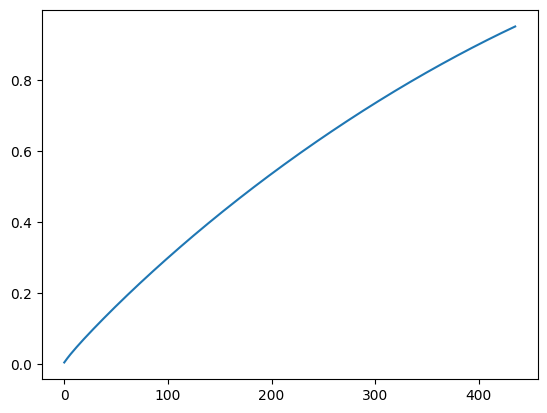

In [6]:
X = dataset.drop(columns=['Output','Cluster'])
y = dataset['Output']

scalar = StandardScaler()
scaled_x = scalar.fit_transform(X)

pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(scaled_x)

plt.plot(pca.explained_variance_ratio_.cumsum())

In [7]:
pca.explained_variance_ratio_.cumsum()

array([0.00508939, 0.00922994, 0.01319651, 0.01705083, 0.02084856,
       0.0245828 , 0.02817524, 0.03166713, 0.03514293, 0.03860684,
       0.0419816 , 0.04533787, 0.04864858, 0.05194313, 0.0552263 ,
       0.05849102, 0.06172089, 0.06492942, 0.06811049, 0.07127056,
       0.07441362, 0.07754889, 0.08066778, 0.08377366, 0.08687355,
       0.08995619, 0.09301886, 0.09607455, 0.09912318, 0.10215718,
       0.10518708, 0.10821139, 0.11121606, 0.11421229, 0.11720413,
       0.12019282, 0.12316451, 0.12612865, 0.12908798, 0.13204274,
       0.13498668, 0.13792137, 0.14085516, 0.14378105, 0.14669928,
       0.14961397, 0.15252138, 0.1554167 , 0.15830121, 0.16117318,
       0.1640408 , 0.16690274, 0.16975576, 0.1726003 , 0.17544123,
       0.17827425, 0.18110447, 0.18392815, 0.18674255, 0.18955035,
       0.19235017, 0.19514846, 0.1979415 , 0.20072715, 0.20350578,
       0.20627898, 0.20904937, 0.21181294, 0.21456973, 0.21732245,
       0.22006427, 0.22280421, 0.22553952, 0.22826109, 0.23097

In [13]:
def experiment(X,y):
    result_dict = {}
    # X = df.drop(columns=['Good/Bad'])
    # y = df['Good/Bad']
    # y = np.where(y==-1,1,0)
    # scalar = StandardScaler()
    # x_scaled = scalar.fit_transform(X)

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20)
    
    print("Using logistcregression")
    lg = LogisticRegression()
    lg.fit(X_train,y_train)
    result_dict['LogisticRegression'] = {'training_score':lg.score(X_train,y_train),'test_score':lg.score(X_test,y_test)}
    
   
    
    print("Using DecisionTree")
    model = DecisionTreeClassifier()
    model.fit(X_train,y_train)
    result_dict['DecisionTree'] = {'training_score':model.score(X_train,y_train),'test_score':model.score(X_test,y_test)}

    print("Using Randomforest")
    model = RandomForestClassifier()
    model.fit(X_train,y_train)
    result_dict['Randomforest'] = {'training_score':model.score(X_train,y_train),'test_score':model.score(X_test,y_test)}

    print("Using svc")
    model = SVC()
    model.fit(X_train,y_train)
    result_dict['SVC'] = {'training_score':model.score(X_train,y_train),'test_score':model.score(X_test,y_test)}

    print("Using KNeighborsClassifier")
    model = KNeighborsClassifier(n_neighbors=2)
    model.fit(X_train,y_train)
    result_dict['KNN'] = {'training_score':model.score(X_train,y_train),'test_score':model.score(X_test,y_test)}

    print("Using GaussianNB")
    model = GaussianNB()
    model.fit(X_train,y_train)
    result_dict['GaussianNB'] = {'training_score':model.score(X_train,y_train),'test_score':model.score(X_test,y_test)}


    print("Using XGBClassifier")
    model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
    model.fit(X_train,y_train)
    result_dict['XGBClassifier'] = {'training_score':model.score(X_train,y_train),'test_score':model.score(X_test,y_test)}


    return pd.DataFrame(result_dict)
     

In [16]:
models_list = {
    "LogisticRegression":LogisticRegression(),
    "DecisionTreeClassifier":DecisionTreeClassifier(),
    "RandomForestClassifier":RandomForestClassifier(),
    "SVC":SVC(),
    "KNeighborsClassifier":KNeighborsClassifier(),
    "GaussianNB":GaussianNB(),
    "XGBClassifier":XGBClassifier(eval_metric='logloss', use_label_encoder=False)
}

In [14]:
experiment(scaled_x,y)

Using logistcregression
Using DecisionTree
Using Randomforest
Using svc
Using KNeighborsClassifier
Using GaussianNB
Using XGBClassifier


e:\data science\Projects\SENSOR-FAULT-DETECTION\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,LogisticRegression,DecisionTree,Randomforest,SVC,KNN,GaussianNB,XGBClassifier
training_score,0.620360,1.000000,1.00000,0.957942,0.990760,0.617811,1.000000
test_score,0.531295,0.518395,0.56474,0.562351,0.555662,0.526995,0.545628


In [15]:
from sklearn.model_selection import StratifiedKFold,cross_val_score
def cross_validation_score(clf,X,y):
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf,X,y,cv=stratified_kfold)
    print(np.mean(scores),np.std(scores))

In [20]:
for model in models_list:
    print(model)
    print(cross_val_score(models_list[model],scaled_x,y))

LogisticRegression
[0.48685783 0.49701314 0.5        0.48566308 0.50179211]
DecisionTreeClassifier
[0.57825568 0.49223417 0.51135006 0.609319   0.51194743]
RandomForestClassifier
[0.59677419 0.47491039 0.48805257 0.59737157 0.51851852]
SVC
[0.58363202 0.47968937 0.49940263 0.57945042 0.51911589]
KNeighborsClassifier
[0.54540024 0.54540024 0.54480287 0.54480287 0.54480287]
GaussianNB
[0.59378734 0.47550777 0.47072879 0.59557945 0.51612903]
XGBClassifier


e:\data science\Projects\SENSOR-FAULT-DETECTION\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:23:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
e:\data science\Projects\SENSOR-FAULT-DETECTION\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:23:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
e:\data science\Projects\SENSOR-FAULT-DETECTION\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:23:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not u

KeyboardInterrupt: 

In [19]:
# Define the FunctionTransformer for each function
drop_unwanted_columns_ = FunctionTransformer(func=drop_unwanted_columns)
drop_dublicate_rows_ = FunctionTransformer(func=drop_dublicate_rows)

preprocessing_pipeline = Pipeline(
    [
        ("drop_unwanted_columns", drop_unwanted_columns_),
        ("drop_dublicate_rows", drop_dublicate_rows_),
        ("drop_zero_std_columns", HandleZeroStdColumns()),
        ("handle_nan_values", HandleNaNValues()),
        ("handle_high_skew_columns",HandleHighSkewColumns()),
        ("handle_outlier", OutlierHandler())
    ]
)



In [21]:
final_pipeline = Pipeline([
    # Step 1: Apply the preprocessing pipeline to the entire data
    ('preprocessing', preprocessing_pipeline),
    
    # Step 2: Apply ColumnTransformer while excluding the target column 'Good/Bad'
    ('feature_processing', ColumnTransformer(
        transformers=[
            ("scaling_features", StandardScaler(), slice(0, -1)),  # Exclude the last column if it's the target
            ('pca', PCA(n_components=), slice(0, -1))  # Exclude the last column if it's the target
        ]
    )),
    
    # Step 3: Add your classifier (e.g., RandomForestClassifier)
    ('classifier', RandomForestClassifier())
])

2024-09-05 01:29:42,625 - INFO - DropZeroStdColumns  fitted successfully.
2024-09-05 01:29:42,628 - INFO - DropZeroStdColumns columns transform successfully
2024-09-05 01:29:42,630 - INFO - DropZeroStdColumns Fit and transform completed successfully.
2024-09-05 01:29:42,634 - INFO - Columns to drop due to high NaN percentage: ['Sensor-73', 'Sensor-74', 'Sensor-86', 'Sensor-113', 'Sensor-158', 'Sensor-159', 'Sensor-221', 'Sensor-248', 'Sensor-293', 'Sensor-294', 'Sensor-346', 'Sensor-347', 'Sensor-359', 'Sensor-386', 'Sensor-493', 'Sensor-520', 'Sensor-579', 'Sensor-580', 'Sensor-581', 'Sensor-582']
2024-09-05 01:29:42,652 - INFO - KNN Imputer fitted successfully.


Dropped columns :: Status: Success :: droped_columns:['Unnamed: 0']
Dropped Dublicate rows :: Status: Sucess :: no_of_rows_dropped:0


2024-09-05 01:29:42,656 - INFO - Applied column dropping. Remaining columns: ['Sensor-1', 'Sensor-2', 'Sensor-3', 'Sensor-4', 'Sensor-5', 'Sensor-7', 'Sensor-8', 'Sensor-9', 'Sensor-10', 'Sensor-11', 'Sensor-12', 'Sensor-13', 'Sensor-15', 'Sensor-16', 'Sensor-17', 'Sensor-18', 'Sensor-19', 'Sensor-20', 'Sensor-21', 'Sensor-22', 'Sensor-23', 'Sensor-24', 'Sensor-25', 'Sensor-26', 'Sensor-27', 'Sensor-28', 'Sensor-29', 'Sensor-30', 'Sensor-31', 'Sensor-32', 'Sensor-33', 'Sensor-34', 'Sensor-35', 'Sensor-36', 'Sensor-37', 'Sensor-38', 'Sensor-39', 'Sensor-40', 'Sensor-41', 'Sensor-42', 'Sensor-44', 'Sensor-45', 'Sensor-46', 'Sensor-47', 'Sensor-48', 'Sensor-49', 'Sensor-51', 'Sensor-52', 'Sensor-54', 'Sensor-55', 'Sensor-56', 'Sensor-57', 'Sensor-58', 'Sensor-59', 'Sensor-60', 'Sensor-61', 'Sensor-62', 'Sensor-63', 'Sensor-64', 'Sensor-65', 'Sensor-66', 'Sensor-67', 'Sensor-68', 'Sensor-69', 'Sensor-71', 'Sensor-72', 'Sensor-75', 'Sensor-76', 'Sensor-77', 'Sensor-78', 'Sensor-79', 'Sensor

,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-7,Sensor-8,Sensor-9,Sensor-10,Sensor-11,...,Sensor-578,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
0,3045.98,2544.85,2253.3444,0.848884,-0.360693,94.9722,-0.703053,1.4752,0.0084,0.0009,...,-0.136922,0.4948,-0.427469,-0.317300,-0.343649,0.612688,-0.679707,-0.642184,-0.843165,-1.0
1,3151.98,2563.75,2175.2556,-0.922856,-0.054447,100.6222,1.220386,1.4536,-0.0110,-0.0035,...,-1.505811,0.5063,-0.761426,-0.612515,-0.781764,0.612688,-0.679707,-0.642184,-0.843165,-1.0
2,3071.18,2489.86,2195.3000,-0.602893,-1.190097,103.5467,0.249939,1.4826,0.0136,0.0009,...,-0.136922,0.5033,-0.796515,-0.928799,-0.774958,0.612688,-0.679707,-0.642184,-0.843165,-1.0
3,2958.46,2523.78,2171.8556,-0.591559,0.225477,100.1367,0.820070,1.4645,0.0001,0.0067,...,-0.136922,0.4954,-0.036158,-0.317300,0.053312,0.612688,-0.679707,-0.642184,-0.843165,-1.0
4,3196.21,2413.39,2255.5222,0.653216,-0.212134,101.5878,-1.065635,1.4845,-0.0037,0.0049,...,2.185252,0.5058,-1.485724,-1.446057,-1.564059,-1.666361,0.625782,0.524942,2.239759,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,3169.00,2265.60,2187.9889,-0.736697,-1.251557,97.6567,-0.255326,1.4109,-0.0239,-0.0121,...,2.291591,0.4912,-0.302128,0.455542,-0.189519,-0.441306,-0.314633,-0.464545,0.089354,-1.0
833,2923.19,2516.40,2180.8889,-0.765384,-1.243554,94.2467,-0.033213,1.3137,0.0345,-0.0137,...,-2.091920,0.4939,0.643462,0.215460,0.678254,-0.441306,-0.314633,-0.464545,0.089354,-1.0
834,3003.43,2448.34,2205.5000,-0.292542,1.618700,111.7644,0.711226,1.4339,0.0020,-0.0036,...,-0.335312,0.4966,-1.920169,-2.655874,-2.046114,-0.441306,-0.314633,-0.464545,0.089354,-1.0
835,2953.63,2500.05,2195.9778,-0.074954,0.545247,103.2400,0.348546,1.5177,0.0183,-0.0137,...,-2.077465,0.5009,-0.064653,-0.041746,-0.011315,-0.327654,1.614351,1.725400,1.216469,-1.0


In [29]:
final_pipeline = Pipeline([
    # Step 1: Apply the preprocessing pipeline to the entire data
    ('preprocessing', preprocessing_pipeline),
    
    # Step 2: Apply ColumnTransformer while excluding the target column 'Good/Bad'
    ('feature_processing', ColumnTransformer(
        transformers=[
            ("scaling_features", StandardScaler(), slice(0, -1)),  # Exclude the last column if it's the target
        ],

    remainder='passthrough'  # Keep the target column as it as
    ))

    
    
])

In [26]:
final_pipeline.

2024-09-05 01:33:56,966 - INFO - DropZeroStdColumns  fitted successfully.
2024-09-05 01:33:56,969 - INFO - DropZeroStdColumns columns transform successfully
2024-09-05 01:33:56,971 - INFO - DropZeroStdColumns Fit and transform completed successfully.
2024-09-05 01:33:56,976 - INFO - Columns to drop due to high NaN percentage: ['Sensor-73', 'Sensor-74', 'Sensor-86', 'Sensor-113', 'Sensor-158', 'Sensor-159', 'Sensor-221', 'Sensor-248', 'Sensor-293', 'Sensor-294', 'Sensor-346', 'Sensor-347', 'Sensor-359', 'Sensor-386', 'Sensor-493', 'Sensor-520', 'Sensor-579', 'Sensor-580', 'Sensor-581', 'Sensor-582']
2024-09-05 01:33:56,992 - INFO - KNN Imputer fitted successfully.


Dropped columns :: Status: Success :: droped_columns:['Unnamed: 0']
Dropped Dublicate rows :: Status: Sucess :: no_of_rows_dropped:0


2024-09-05 01:33:56,997 - INFO - Applied column dropping. Remaining columns: ['Sensor-1', 'Sensor-2', 'Sensor-3', 'Sensor-4', 'Sensor-5', 'Sensor-7', 'Sensor-8', 'Sensor-9', 'Sensor-10', 'Sensor-11', 'Sensor-12', 'Sensor-13', 'Sensor-15', 'Sensor-16', 'Sensor-17', 'Sensor-18', 'Sensor-19', 'Sensor-20', 'Sensor-21', 'Sensor-22', 'Sensor-23', 'Sensor-24', 'Sensor-25', 'Sensor-26', 'Sensor-27', 'Sensor-28', 'Sensor-29', 'Sensor-30', 'Sensor-31', 'Sensor-32', 'Sensor-33', 'Sensor-34', 'Sensor-35', 'Sensor-36', 'Sensor-37', 'Sensor-38', 'Sensor-39', 'Sensor-40', 'Sensor-41', 'Sensor-42', 'Sensor-44', 'Sensor-45', 'Sensor-46', 'Sensor-47', 'Sensor-48', 'Sensor-49', 'Sensor-51', 'Sensor-52', 'Sensor-54', 'Sensor-55', 'Sensor-56', 'Sensor-57', 'Sensor-58', 'Sensor-59', 'Sensor-60', 'Sensor-61', 'Sensor-62', 'Sensor-63', 'Sensor-64', 'Sensor-65', 'Sensor-66', 'Sensor-67', 'Sensor-68', 'Sensor-69', 'Sensor-71', 'Sensor-72', 'Sensor-75', 'Sensor-76', 'Sensor-77', 'Sensor-78', 'Sensor-79', 'Sensor

In [31]:
scaled_data = final_pipeline.fit_transform(df_1)
scaled_data.shape

2024-09-05 01:44:23,023 - INFO - DropZeroStdColumns  fitted successfully.
2024-09-05 01:44:23,027 - INFO - DropZeroStdColumns columns transform successfully
2024-09-05 01:44:23,028 - INFO - DropZeroStdColumns Fit and transform completed successfully.
2024-09-05 01:44:23,035 - INFO - Columns to drop due to high NaN percentage: ['Sensor-73', 'Sensor-74', 'Sensor-86', 'Sensor-113', 'Sensor-158', 'Sensor-159', 'Sensor-221', 'Sensor-248', 'Sensor-293', 'Sensor-294', 'Sensor-346', 'Sensor-347', 'Sensor-359', 'Sensor-386', 'Sensor-493', 'Sensor-520', 'Sensor-579', 'Sensor-580', 'Sensor-581', 'Sensor-582']
2024-09-05 01:44:23,058 - INFO - KNN Imputer fitted successfully.


Dropped columns :: Status: Success :: droped_columns:['Unnamed: 0']
Dropped Dublicate rows :: Status: Sucess :: no_of_rows_dropped:0


2024-09-05 01:44:23,063 - INFO - Applied column dropping. Remaining columns: ['Sensor-1', 'Sensor-2', 'Sensor-3', 'Sensor-4', 'Sensor-5', 'Sensor-7', 'Sensor-8', 'Sensor-9', 'Sensor-10', 'Sensor-11', 'Sensor-12', 'Sensor-13', 'Sensor-15', 'Sensor-16', 'Sensor-17', 'Sensor-18', 'Sensor-19', 'Sensor-20', 'Sensor-21', 'Sensor-22', 'Sensor-23', 'Sensor-24', 'Sensor-25', 'Sensor-26', 'Sensor-27', 'Sensor-28', 'Sensor-29', 'Sensor-30', 'Sensor-31', 'Sensor-32', 'Sensor-33', 'Sensor-34', 'Sensor-35', 'Sensor-36', 'Sensor-37', 'Sensor-38', 'Sensor-39', 'Sensor-40', 'Sensor-41', 'Sensor-42', 'Sensor-44', 'Sensor-45', 'Sensor-46', 'Sensor-47', 'Sensor-48', 'Sensor-49', 'Sensor-51', 'Sensor-52', 'Sensor-54', 'Sensor-55', 'Sensor-56', 'Sensor-57', 'Sensor-58', 'Sensor-59', 'Sensor-60', 'Sensor-61', 'Sensor-62', 'Sensor-63', 'Sensor-64', 'Sensor-65', 'Sensor-66', 'Sensor-67', 'Sensor-68', 'Sensor-69', 'Sensor-71', 'Sensor-72', 'Sensor-75', 'Sensor-76', 'Sensor-77', 'Sensor-78', 'Sensor-79', 'Sensor

(837, 455)

In [37]:
X = scaled_data[:,:-1]
y = scaled_data[:,-1]

In [53]:
pca = PCA(n_components=0.99)

pca_data  = pca.fit_transform(X)

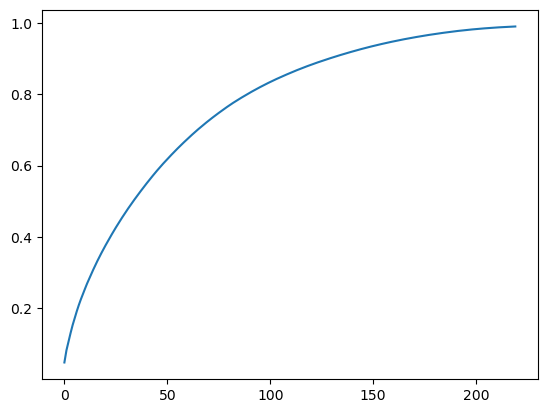

In [54]:
plt.plot(pca.explained_variance_ratio_.cumsum())

In [56]:
experiment(pca_data,y)

Using logistcregression
Using DecisionTree
Using Randomforest
Using svc
Using KNeighborsClassifier
Using GaussianNB
Using XGBClassifier


,LogisticRegression,DecisionTree,Randomforest,SVC,KNN,GaussianNB,XGBClassifier
training_score,1.000000,1.000000,1.000000,0.960128,0.961722,0.995215,1.000000
test_score,0.919048,0.890476,0.942857,0.942857,0.942857,0.938095,0.942857


In [57]:
from sklearn.cluster import KMeans

In [68]:
WCSS =[]
for cluster in range(1,10):
    kmeans = KMeans(n_clusters=cluster)
    kmeans.fit(pca_data)
    WCSS.append(kmeans.inertia_)
    

C:\Users\RAVEEN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\RAVEEN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\RAVEEN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\RAVEEN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Wi

Text(0, 0.5, 'WCSS')

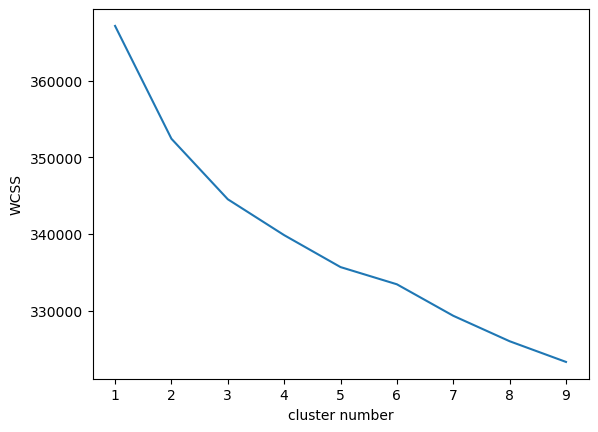

In [69]:
plt.plot(range(1,10), WCSS)
plt.xlabel('cluster number')
plt.ylabel('WCSS')

In [97]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import os 

os.environ['OMP_NUM_THREADS']="4"
# Assuming X is your feature set and y are the labels

pca_x = d6.drop(columns=['Good/Bad'])
y = d6['Good/Bad']
# Step 2: Find Optimal Number of Clusters using K-Means
# Elbow Method (Knee Locator)
# Calculate inertia for each number of clusters
inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)

kneedle = KneeLocator(range(1, 11), inertia, curve='convex', direction='decreasing')
optimal_clusters = kneedle.elbow
print(f"Optimal number of clusters based on Elbow Method: {optimal_clusters}")

# # Get the optimal number of clusters
# optimal_clusters = kneedle.elbow
# print(f"Optimal number of clusters based on Elbow Method: {optimal_clusters}")

# Fit K-Means with optimal number of clusters
kmeans = KMeans(n_clusters=3 ,random_state=42)
clusters = kmeans.fit_predict(pca_x)

# Add cluster labels to the data
X_clusters = pd.DataFrame(pca_x)
X_clusters['Cluster'] = clusters
y_clusters = pd.Series(y, name='Target')

# Step 3: Evaluate Clusters using Silhouette Score
silhouette_avg = silhouette_score(pca_x, clusters)
print(f"Silhouette Score: {silhouette_avg:.4f}")


C:\Users\RAVEEN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\RAVEEN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\RAVEEN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\RAVEEN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Wi

Optimal number of clusters based on Elbow Method: 3
Silhouette Score: 0.4565


C:\Users\RAVEEN\AppData\Local\Temp\ipykernel_14320\2107068146.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_clusters['Cluster'] = clusters


In [100]:
X_clusters['Good/Bad'] = np.where(y==-1,1,0)

C:\Users\RAVEEN\AppData\Local\Temp\ipykernel_14320\3579241897.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_clusters['Good/Bad'] = np.where(y==-1,1,0)


In [101]:
X_clusters

,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-7,Sensor-8,Sensor-9,Sensor-10,Sensor-11,...,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Cluster,Good/Bad
0,3045.98,2544.85,2253.3444,0.848884,-0.360693,94.9722,-0.703053,1.4752,0.0084,0.0009,...,0.4948,-0.427469,-0.317300,-0.343649,0.612688,-0.679707,-0.642184,-0.843165,2,1
1,3151.98,2563.75,2175.2556,-0.922856,-0.054447,100.6222,1.220386,1.4536,-0.0110,-0.0035,...,0.5063,-0.761426,-0.612515,-0.781764,0.612688,-0.679707,-0.642184,-0.843165,2,1
2,3071.18,2489.86,2195.3000,-0.602893,-1.190097,103.5467,0.249939,1.4826,0.0136,0.0009,...,0.5033,-0.796515,-0.928799,-0.774958,0.612688,-0.679707,-0.642184,-0.843165,1,1
3,2958.46,2523.78,2171.8556,-0.591559,0.225477,100.1367,0.820070,1.4645,0.0001,0.0067,...,0.4954,-0.036158,-0.317300,0.053312,0.612688,-0.679707,-0.642184,-0.843165,2,1
4,3196.21,2413.39,2255.5222,0.653216,-0.212134,101.5878,-1.065635,1.4845,-0.0037,0.0049,...,0.5058,-1.485724,-1.446057,-1.564059,-1.666361,0.625782,0.524942,2.239759,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,3169.00,2265.60,2187.9889,-0.736697,-1.251557,97.6567,-0.255326,1.4109,-0.0239,-0.0121,...,0.4912,-0.302128,0.455542,-0.189519,-0.441306,-0.314633,-0.464545,0.089354,0,1
833,2923.19,2516.40,2180.8889,-0.765384,-1.243554,94.2467,-0.033213,1.3137,0.0345,-0.0137,...,0.4939,0.643462,0.215460,0.678254,-0.441306,-0.314633,-0.464545,0.089354,2,1
834,3003.43,2448.34,2205.5000,-0.292542,1.618700,111.7644,0.711226,1.4339,0.0020,-0.0036,...,0.4966,-1.920169,-2.655874,-2.046114,-0.441306,-0.314633,-0.464545,0.089354,2,1
835,2953.63,2500.05,2195.9778,-0.074954,0.545247,103.2400,0.348546,1.5177,0.0183,-0.0137,...,0.5009,-0.064653,-0.041746,-0.011315,-0.327654,1.614351,1.725400,1.216469,2,1


In [102]:
final_data  = X_clusters.copy()

In [103]:
final_data['Cluster'].value_counts()

Cluster
2    634
1    129
0     74
Name: count, dtype: int64

In [104]:
final_data['Good/Bad'].value_counts()

Good/Bad
1    800
0     37
Name: count, dtype: int64

In [118]:
def experiment(X,y):
    result_dict = {}
    # X = df.drop(columns=['Good/Bad'])
    # y = df['Good/Bad']
    # y = np.where(y==-1,1,0)
    scalar = StandardScaler()
    x_scaled = scalar.fit_transform(X)
    pca_data 

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=10)
    
    print("Using logistcregression")
    lg = LogisticRegression()
    lg.fit(X_train,y_train)
    result_dict['LogisticRegression'] = {'training_score':lg.score(X_train,y_train),'test_score':lg.score(X_test,y_test)}
    
   
    
    print("Using DecisionTree")
    model = DecisionTreeClassifier()
    model.fit(X_train,y_train)
    result_dict['DecisionTree'] = {'training_score':model.score(X_train,y_train),'test_score':model.score(X_test,y_test)}

    print("Using Randomforest")
    model = RandomForestClassifier()
    model.fit(X_train,y_train)
    result_dict['Randomforest'] = {'training_score':model.score(X_train,y_train),'test_score':model.score(X_test,y_test)}

    print("Using svc")
    model = SVC()
    model.fit(X_train,y_train)
    result_dict['SVC'] = {'training_score':model.score(X_train,y_train),'test_score':model.score(X_test,y_test)}

    print("Using KNeighborsClassifier")
    model = KNeighborsClassifier()
    model.fit(X_train,y_train)
    result_dict['KNN'] = {'training_score':model.score(X_train,y_train),'test_score':model.score(X_test,y_test)}

    print("Using GaussianNB")
    model = GaussianNB()
    model.fit(X_train,y_train)
    result_dict['GaussianNB'] = {'training_score':model.score(X_train,y_train),'test_score':model.score(X_test,y_test)}


    print("Using XGBClassifier")
    model = XGBClassifier()
    model.fit(X_train,y_train)
    result_dict['XGBClassifier'] = {'training_score':model.score(X_train,y_train),'test_score':model.score(X_test,y_test)}


    return pd.DataFrame(result_dict)
     

In [123]:
final_result = {}
for i in range(3):
    data = final_data[final_data['Cluster']==i]
    X = data.drop(columns=['Cluster','Good/Bad'])
    y = data['Good/Bad']
    scaled_data = StandardScaler().fit_transform(X)
    pca_data = PCA(n_components=0.99).fit_transform(scaled_data)
    smote = SMOTE(k_neighbors=2,random_state=42)
    cluster_X_resampled, cluster_y_resampled = smote.fit_resample(pca_data, y)
    print(cluster_y_resampled.value_counts())
    final_result[f'cluster_no:{i}']=experiment(cluster_X_resampled,cluster_y_resampled)
    

Good/Bad
0    71
1    71
Name: count, dtype: int64
Using logistcregression
Using DecisionTree
Using Randomforest
Using svc
Using KNeighborsClassifier
Using GaussianNB
Using XGBClassifier
Good/Bad
1    125
0    125
Name: count, dtype: int64
Using logistcregression
Using DecisionTree
Using Randomforest
Using svc
Using KNeighborsClassifier
Using GaussianNB
Using XGBClassifier
Good/Bad
1    604
0    604
Name: count, dtype: int64
Using logistcregression
Using DecisionTree
Using Randomforest
Using svc
Using KNeighborsClassifier
Using GaussianNB
Using XGBClassifier


In [125]:
final_result{'cluster_no:0':                 LogisticRegression  DecisionTree  Randomforest  SVC       KNN  \
 training_score                 1.0           1.0           1.0  1.0  0.716814   
 test_score                     1.0           1.0           1.0  1.0  0.586207   
 
                 GaussianNB  XGBClassifier  
 training_score         1.0       1.000000  
 test_score             1.0       0.965517  ,
 'cluster_no:1':                 LogisticRegression  DecisionTree  Randomforest  SVC    KNN  \
 training_score                 1.0          1.00           1.0  1.0  0.595   
 test_score                     1.0          0.94           1.0  1.0  0.540   
 
                 GaussianNB  XGBClassifier  
 training_score        0.98            1.0  
 test_score            0.96            1.0  ,
 'cluster_no:2':                 LogisticRegression  DecisionTree  Randomforest  SVC       KNN  \
 training_score            1.000000      1.000000      1.000000  1.0  0.670807   
 test_score                0.966942      0.929752      0.995868  1.0  0.590909   
 
                 GaussianNB  XGBClassifier  
 training_score    0.937888       1.000000  
 test_score        0.942149       0.995868  }

{'cluster_no:0':                 LogisticRegression  DecisionTree  Randomforest  SVC       KNN  \
 training_score                 1.0           1.0           1.0  1.0  0.716814   
 test_score                     1.0           1.0           1.0  1.0  0.586207   
 
                 GaussianNB  XGBClassifier  
 training_score         1.0       1.000000  
 test_score             1.0       0.965517  ,
 'cluster_no:1':                 LogisticRegression  DecisionTree  Randomforest  SVC    KNN  \
 training_score                 1.0          1.00           1.0  1.0  0.595   
 test_score                     1.0          0.94           1.0  1.0  0.540   
 
                 GaussianNB  XGBClassifier  
 training_score        0.98            1.0  
 test_score            0.96            1.0  ,
 'cluster_no:2':                 LogisticRegression  DecisionTree  Randomforest  SVC       KNN  \
 training_score            1.000000      1.000000      1.000000  1.0  0.670807   
 test_score                0.

In [88]:
df['Good/Bad'].value_counts()

Good/Bad
-1    800
 1     37
Name: count, dtype: int64

In [84]:
from sklearn.model_selection import RandomizedSearchCV
from hdbscan import HDBSCAN
from sklearn.metrics import make_scorer, silhouette_score

def silhouette_scorer(estimator, X):
    # Predict the cluster labels
    labels = estimator.labels_
    # Check if there's more than 1 cluster
    if len(set(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return -1  # Return a negative score if only one cluster exists

silhouette_scorer = make_scorer(silhouette_scorer, greater_is_better=True)
# Define the parameter grid
param_grid = {
    'min_cluster_size': [5, 10, 15, 20, 50],
    'min_samples': [1, 5, 10, 15, 20],
    'cluster_selection_epsilon': [0.0, 0.01, 0.05, 0.1],
    # 'metric': ['euclidean', 'manhattan', 'cosine']
}

# Define the HDBSCAN model
clusterer = HDBSCAN()

# RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(
    estimator=clusterer,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring=silhouette_scorer,  # Define the scoring strategy
    cv=5
)

# Fit the random search
random_search.fit(pca_data)
print("Best Parameters:", random_search.best_params_)
print("Best Silhouette Score:", random_search.best_score_)



C:\Users\RAVEEN\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RAVEEN\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\RAVEEN\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RAVEEN\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^

Best Parameters: {'min_samples': 20, 'min_cluster_size': 5, 'cluster_selection_epsilon': 0.1}
Best Silhouette Score: nan


In [86]:
import numpy as np
import hdbscan
from sklearn.metrics import silhouette_score

# Define the parameter grid
param_grid = {
    'min_cluster_size': [5, 10, 15, 20, 50],
    'min_samples': [1, 5, 10, 15, 20],
    'cluster_selection_epsilon': [0.0, 0.01, 0.05, 0.1],
    'metric': ['euclidean', 'manhattan']
}

# Store best params and best score
best_params = None
best_score = -1

# Manual grid search
for min_cluster_size in param_grid['min_cluster_size']:
    for min_samples in param_grid['min_samples']:
        for epsilon in param_grid['cluster_selection_epsilon']:
            for metric in param_grid['metric']:
                # Initialize HDBSCAN with current parameters
                clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                            min_samples=min_samples,
                                            cluster_selection_epsilon=epsilon,
                                            metric=metric)
                
                # Fit HDBSCAN
                cluster_labels = clusterer.fit_predict(pca_data)
                
                # Calculate silhouette score (only valid if more than one cluster)
                if len(np.unique(cluster_labels)) > 1:
                    score = silhouette_score(X, cluster_labels)
                    print(f'Params: min_cluster_size={min_cluster_size}, min_samples={min_samples}, epsilon={epsilon}, metric={metric}, Score: {score:.4f}')
                    
                    if score > best_score:
                        best_score = score
                        best_params = {
                            'min_cluster_size': min_cluster_size,
                            'min_samples': min_samples,
                            'cluster_selection_epsilon': epsilon,
                            'metric': metric
                        }

print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_score)


Params: min_cluster_size=5, min_samples=1, epsilon=0.0, metric=euclidean, Score: 0.0596
Params: min_cluster_size=5, min_samples=1, epsilon=0.0, metric=manhattan, Score: 0.0578
Params: min_cluster_size=5, min_samples=1, epsilon=0.01, metric=euclidean, Score: 0.0596
Params: min_cluster_size=5, min_samples=1, epsilon=0.01, metric=manhattan, Score: 0.0578
Params: min_cluster_size=5, min_samples=1, epsilon=0.05, metric=euclidean, Score: 0.0596
Params: min_cluster_size=5, min_samples=1, epsilon=0.05, metric=manhattan, Score: 0.0578
Params: min_cluster_size=5, min_samples=1, epsilon=0.1, metric=euclidean, Score: 0.0596
Params: min_cluster_size=5, min_samples=1, epsilon=0.1, metric=manhattan, Score: 0.0578
Params: min_cluster_size=5, min_samples=5, epsilon=0.0, metric=euclidean, Score: 0.0127
Params: min_cluster_size=5, min_samples=5, epsilon=0.0, metric=manhattan, Score: -0.0830
Params: min_cluster_size=5, min_samples=5, epsilon=0.01, metric=euclidean, Score: 0.0127
Params: min_cluster_size=5